In [2]:
import matplotlib.pyplot as plt
import os

print("tiny experiments")

save_dir = './tiny_imgs/'
os.makedirs(save_dir, exist_ok=True)

tiny experiments


Observation 1

In [ ]:
ks = [1, 2, 3, 4, 5, 6]

# gsm8k
# score = [52.92, 50.04, 47.16, 44.81, 42.38, 41.55]
# tps = [21.22, 41.33, 61.55, 82.66, 101.85, 122.87]
# title = 'GSM8K gen_len=256'

# math-500
score = [25.8, 25.4, 25, 22.2, 21.2, 19]
tps = [19.93, 39.83, 59.23, 79.90, 98.50, 119.10]
title = 'Math-500 gen_len=256'

fig, ax2 = plt.subplots(figsize=(6, 5))

color_tps = 'tab:blue'
ax2.set_ylabel('Tps', color=color_tps)
bar_plot = ax2.bar(ks, tps, width=0.5, color=color_tps, alpha=0.7, label='Tps')
ax2.tick_params(axis='y', labelcolor=color_tps)
ax2.set_xlabel('K')
ax2.set_xticks(ks)

ax1 = ax2.twinx()
color_score = 'tab:red'
ax1.set_ylabel('Accuracy%', color=color_score)
line_plot, = ax1.plot(
    ks, score,
    color=color_score,
    marker='o',
    linestyle='-',
    label='Accuracy%',
    markerfacecolor=color_score,
    markeredgecolor=color_score,
    markeredgewidth=1.5
)
ax1.tick_params(axis='y', labelcolor=color_score)

# plt.title(title)

# 合并图例（使用 ax1 的位置显示）
plots = [bar_plot, line_plot]
labels = [p.get_label() for p in plots]
ax1.legend(plots, labels, loc='upper right')

fig.tight_layout()
fig.savefig(f'tiny_imgs/{title}.png', dpi=150, bbox_inches='tight')
# plt.show()

Observation 2: Temporal Attention Map

In [4]:
from sampler.BaseSampler import GenerateOutput
from sampler.PureDLLMSampler import PureDLLMSamplerConfig, PureDLLMSampler
from visualizer import get_local
from datasets import load_dataset
import torch
import numpy as np

gen_length = 128
block_length = 128

In [ ]:
dataset = load_dataset('openai/gsm8k', 'main')
prompts = dataset['test']['question'][0:1]

get_local.activate()  # 在引入模型之前，激活装饰器
key = 'LLaDABlock._manually_scaled_dot_product_attention'
model_path = "../models/LLaDA-8B-Instruct"
config = PureDLLMSamplerConfig(
    cfg_scale=0.0,
    temperature=0.0,
    positional_weights_type='none',
    max_weight=1.0,
    initial_min_weight=0.0,
    remasking="low_confidence",
    decoding_method="topk",
    k=2
)
device="cuda:1"

sampler = PureDLLMSampler.from_path(
    model_path=model_path,
    device=device,
    config=config,
    torch_dtype=torch.bfloat16
)
tokenizer = sampler.tokenizer

get_local.cache[key] = []
for prompt in prompts:
    m = [{"role": "user", "content": prompt}]
    prompt = tokenizer.apply_chat_template(m, add_generation_prompt=True, tokenize=False)
    input_ids = tokenizer(prompt)['input_ids']
    input_ids = torch.tensor(input_ids).to(device).unsqueeze(0)
    OUT: GenerateOutput = sampler.generate(input_ids, gen_length=gen_length, max_steps=gen_length, block_length=block_length)
    actual_steps = OUT.metrics.use_steps

    value_list = get_local.cache[key]
    assert len(value_list) % actual_steps == 0
    n_layers = len(value_list) // actual_steps
    shape_per_layer = value_list[0].shape # (batch_size, heads, seq_len, seq_len)
    steps_attention_maps = np.array(value_list).reshape(
        (actual_steps, n_layers) + shape_per_layer
    ).astype(np.float16) # (steps, N_layers, batch_size, heads, seq_len, seq_len)
    np.save("data/steps_attention_maps.npy", steps_attention_maps)  #save numpy


In [16]:
import matplotlib.pyplot as plt
import os
import numpy as np

loaded_maps = np.load("data/steps_attention_maps.npy")
print("loaded shape:", loaded_maps.shape)
print("loaded type:", loaded_maps.dtype)

attn_maps_resp = loaded_maps[:, :, :, :, -gen_length:, -gen_length:]  # (steps, N_layers, batch_size, heads, gen_len, gen_len)

os.makedirs('tiny_imgs/obs2/', exist_ok=True)

# 1. 预先计算好所有的 step_idx

nrows = 1
ncols = 6
n_plots = nrows * ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 7, nrows * 7), gridspec_kw={'hspace': 0.0, 'wspace': 0.1})

steps = gen_length//2
jump = 12
step_indices = [0] + list(range(jump, steps, jump))

# 4. 扁平化 axes 数组以便于迭代
axes_flat = axes.flat

plot_count = 0

# 5. 使用 zip 同时遍历 step_indices 和 axes_flat
#    zip 会在较短的迭代器（即 axes_flat，长度为 6）耗尽时自动停止
for plot_count, (step_idx, ax) in enumerate(zip(step_indices, axes_flat), 1):

    attn_map_resp_avg = attn_maps_resp[step_idx, :, 0].mean(axis=(0, 1)) # shape: (seq, seq)
    t = gen_length//2 - 1 - step_idx

    im = ax.imshow(attn_map_resp_avg, cmap='viridis', origin="upper", vmin=0, vmax=0.1)
    # fig.colorbar(im, ax=ax, shrink=0.7) # 注意这里 colorbar 也关联到 fig 和 ax

    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    # ax.set_title(f"t={t}")
    ax.text(
        0.5,  # X 坐标 (0.5 = 图像宽度的 50% = 中心)
        0.5,  # Y 坐标 (0.5 = 图像高度的 50% = 中心)
        f"t={t}",
        transform=ax.transAxes, # 确保坐标是相对于图像区域 (0,0)到(1,1)
        fontsize=50,          # 字体大一些 (根据需要调整)
        color='white',        # 字体颜色 (白色或黑色通常效果较好)
        alpha=0.5,            # 半透明 (0.0 到 1.0 之间)
        ha='center',          # 水平居中
        va='center'           # 垂直居中
    )

    # ticks_labels = np.linspace(0, gen_length, 2).astype(int)
    # ticks_positions = np.linspace(-0.5, gen_length - 0.5, 2)
    # ax.set_xticks(ticks_positions)
    # ax.set_yticks(ticks_positions)
    # ax.set_xticklabels(ticks_labels)
    # ax.set_yticklabels(ticks_labels)
    ax.axis('off')

# 7. (可选) 关闭任何未使用的子图
#    如果 step_indices 的长度小于 6，隐藏剩余的空 ax
for i in range(plot_count, n_plots):
    axes_flat[i].axis('off')

fig.colorbar(
    im,                       # 传入 mappable 对象
    ax=axes.ravel().tolist(), # 关键: 将 colorbar 关联到所有 axes
    shrink=0.75,               # (可选) 调整 shrink 以适应整个 fig (原 0.7 可能太小)
    pad=0.02                  # (可选) 在子图和 colorbar 之间添加一点间距
)

# fig.tight_layout()
save_path = f'tiny_imgs/obs2/all_maps_{nrows}x{ncols}.png'
fig.savefig(save_path, dpi=100, bbox_inches='tight')
plt.close()

print(f"成功将 {plot_count} 张 attention maps 绘制到 {save_path}")

loaded shape: (64, 32, 1, 32, 204, 204)
loaded type: float16
成功将 6 张 attention maps 绘制到 tiny_imgs/obs2/all_maps_1x6.png


Ablation: The Effect of N

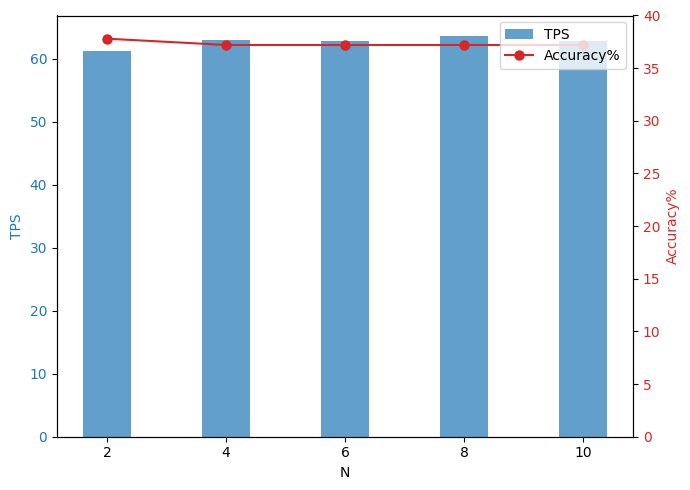

In [38]:
Ns = [2, 4, 6, 8, 10]

# semi-AR
score = [37.8, 37.2, 37.2, 37.2, 37.2]
tps = [61.14, 62.94, 62.77, 63.64, 62.80]
# title = 'N_128-256_humaneval'

#non-AR
# score = [29.88, 29.88, 30.49, 29.27, 28.66]
# tps = [83.65, 86.85, 87.23, 88.55, 88.16]
title = 'N_256-256_humaneval'

fig, ax2 = plt.subplots(figsize=(7, 5))

color_tps = 'tab:blue'
ax2.set_ylabel('TPS', color=color_tps)
bar_plot = ax2.bar(Ns, tps, width=0.8, color=color_tps, alpha=0.7, label='TPS')
ax2.tick_params(axis='y', labelcolor=color_tps)
ax2.set_xlabel('N')
ax2.set_xticks(Ns)

ax1 = ax2.twinx()
color_score = 'tab:red'
ax1.set_ylabel('Accuracy%', color=color_score)
line_plot, = ax1.plot(
    Ns, score,
    color=color_score,
    marker='o',
    linestyle='-',
    label='Accuracy%',
    markerfacecolor=color_score,
    markeredgecolor=color_score,
    markeredgewidth=1.5
)
ax1.tick_params(axis='y', labelcolor=color_score)
ax1.set_ylim(bottom=0, top=40)
# plt.title(title)

plots = [bar_plot, line_plot]
labels = [p.get_label() for p in plots]
ax1.legend(plots, labels, loc='upper right')

fig.tight_layout()
fig.savefig(f'tiny_imgs/{title}.png', dpi=150, bbox_inches='tight')
# plt.show()

Ablation: Decoding Trajectory

In [41]:
import json
import dataclasses
import torch
import numpy as np

def json_converter(obj):
    if isinstance(obj, torch.Tensor):
        return obj.tolist()
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    raise TypeError(f"Object of type {type(obj)} is not JSON serializable")

In [72]:
device = 'cuda:0'
model_path = "../models/LLaDA-8B-Instruct"

gsm8k_dataset = load_dataset('openai/gsm8k', 'main')
prompts = gsm8k_dataset['test']['question'][0:10]

# use llada
model_path = "../models/LLaDA-8B-Instruct"
token_info = {
    'mask_id': 126336,
    'bos_id': 126080,
    'pad_id': 126081,
    'eos_id': 126081,
    'eot_id': 126348
}

# use dream
# model_path = "../models/Dream-7B-Instruct"
# token_info = {
#     'mask_id': 151666,
#     'bos_id': 151665,
#     'pad_id': 151643,
#     'eos_id': 151643,
#     'eot_id': 151643
# }

config = PureDLLMSamplerConfig(
    cfg_scale=0.0,
    temperature=0.0,
    positional_weights_type='none',
    max_weight=1.0,
    initial_min_weight=0.05,
    remasking="low_confidence",
    decoding_method="topk",
    factor=1,
    k=1,
    confidence_threshold=0.9,
    **token_info
)

max_gen_steps = 256
block_length = 256
sampler = PureDLLMSampler.from_path(
    model_path=model_path,
    device=device,
    config=config,
    torch_dtype=torch.bfloat16
)

pmp_idx = 8
tokenizer = sampler.tokenizer
prompt_text = prompts[pmp_idx]
m = [{"role": "user", "content": prompt_text}]
prompt_str = tokenizer.apply_chat_template(m, add_generation_prompt=True, tokenize=False)
input_ids = tokenizer(prompt_str, return_tensors="pt").input_ids.to(device)
OUT = sampler.generate(input_ids, gen_length=max_gen_steps, max_steps=max_gen_steps, block_length=block_length)
out_dict = dataclasses.asdict(OUT)
output_filename = f"data/pure_llada_decoding_trajectory_pmp{pmp_idx}.json"
with open(output_filename, "w") as f:
    json.dump(
        out_dict,
        f,
        indent=2,
        default=json_converter  # [!] 关键
    )


Loading model and tokenizer from path: ../models/LLaDA-8B-Instruct, dllm_type: llada


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

cfg_scale: 0.0
temperature: 0.0
mask_id: 126336
bos_id: 126080
pad_id: 126081
eos_id: 126081
eot_id: 126348
model_max_genlength: 2048
model_max_steps: 2048
positional_weights_type: none
max_weight: 1.0
initial_min_weight: 0.05
ur_factor: 1.2
dllm_type: llada
remasking: low_confidence
decoding_method: topk
k: 1
factor: 1
confidence_threshold: 0.9
decoding method: topk, k=1, factor=1, confidence_threshold=0.9.
block 0 is decoded over in block_step_i=255.
total steps: 256.
GenerationMetrics(use_seconds=208.6143681295216, use_steps=256, n_gen_tokens=256, tokens_per_second=1.227144622373557, step_reduction_ratio=1.0)


Ploting Decoding Trajectory

Plot Pure LLaDA Decoding Trajectory

In [99]:
from matplotlib import patches

def plot_trajectory(confidences, transfer_idxs, save_path, title_text, title_size=120):

    num_steps = len(confidences)
    seq_len = len(confidences[0])

    fig, ax = plt.subplots(figsize=(32, num_steps/seq_len*32))

    # 使用imshow绘制热力图
    im = ax.imshow(confidences, cmap='Blues', interpolation='nearest', vmin=0, vmax=1, aspect='auto')

    ax.text(
        0.5,  # X 坐标 (0.5 = 图像宽度的 50% = 中心)
        0.7,  # Y 坐标 (0.5 = 图像高度的 50% = 中心)
        title_text,
        transform=ax.transAxes, # 确保坐标是相对于图像区域 (0,0)到(1,1)
        fontsize=title_size,          # 字体大一些 (根据需要调整)
        color='black',        # 字体颜色 (白色或黑色通常效果较好)
        alpha=0.4,            # 半透明 (0.0 到 1.0 之间)
        ha='center',          # 水平居中
        va='center'           # 垂直居中
    )
    for i in range(num_steps):
        for j in range(seq_len):
            if transfer_idxs[i][j]:
                rect = patches.Rectangle(
                    (j - 0.5, i - 0.5),
                    1, 1,
                    linewidth=5,          # 设置边框线宽
                    edgecolor='red',      # 设置边框颜色为红色
                    facecolor='none'      # 设置填充色为无，只保留边框
                )
                ax.add_patch(rect)

    ax.axis('off')
    # 设置坐标轴和标签
    # ax.set_xlabel("seq_len", fontsize=fontsize)
    # ax.set_ylabel("step", fontsize=fontsize)
    # 设置刻度，使其显示在每个方格的中心
    # ax.set_xticks([0, seq_len-1])
    # ax.set_yticks([0, seq_len-1])
    # ax.set_xticklabels([1, seq_len])
    # ax.set_yticklabels([1, seq_len])
    # ax.tick_params(axis='both', which='major', labelsize=fontsize)

    fig.tight_layout()

    plt.savefig(save_path, dpi=150)
    plt.close()


In [104]:
pmp_idx = 2
output_filename = f"data/pure_llada_decoding_trajectory_pmp{pmp_idx}.json"

with open(output_filename, "r") as f:
    data = json.load(f)

confidences = data['confidences']
transfer_idxs = data['transfer_idxs']

print(len(confidences), len(confidences[0]))
print(len(transfer_idxs), len(transfer_idxs[0]))
plot_trajectory(confidences, transfer_idxs, f"tiny_imgs/llada_decoding_trajectory_pmp{pmp_idx}.png", "Vanilla", title_size=150)

256 256
256 256


Plot Fast-dLLM decoding trajectorym

In [79]:
from sampler.DiCoSampler import DiCoSamplerConfig, DiCoSampler

device = 'cuda:1'

# base gsm8k prompt
gsm8k_dataset = load_dataset('openai/gsm8k', 'main')
prompts = gsm8k_dataset['test']['question'][0:3]

# llada token info
model_path = "../models/LLaDA-8B-Instruct"
token_info = {
    'mask_id': 126336,
    'bos_id': 126080,
    'pad_id': 126081,
    'eos_id': 126081,
    'eot_id': 126348
}

# dream token info
# model_path = "../models/Dream-7B-Instruct"
# token_info = {
#     'mask_id': 151666,
#     'bos_id': 151665,
#     'pad_id': 151643,
#     'eos_id': 151643,
#     'eot_id': 151643
# }

config = PureDLLMSamplerConfig(
    cfg_scale=0.0,
    temperature=0.0,
    positional_weights_type='none',
    max_weight=1.0,
    initial_min_weight=0.05,
    remasking="low_confidence",
    decoding_method="fixed",
    factor=1,
    k=1,
    confidence_threshold=0.9,
    **token_info
)

max_gen_steps = 256
block_length = 256
sampler = PureDLLMSampler.from_path(
    model_path=model_path,
    device=device,
    config=config,
    torch_dtype=torch.bfloat16
)

pmp_idx = 2
tokenizer = sampler.tokenizer
prompt_text = prompts[pmp_idx]
m = [{"role": "user", "content": prompt_text}]
prompt_str = tokenizer.apply_chat_template(m, add_generation_prompt=True, tokenize=False)
input_ids = tokenizer(prompt_str, return_tensors="pt").input_ids.to(device)
OUT = sampler.generate(input_ids, gen_length=max_gen_steps, max_steps=max_gen_steps, block_length=block_length)
out_dict = dataclasses.asdict(OUT)
output_filename = f"data/fastdllm_decoding_trajectory_pmp{pmp_idx}.json"
with open(output_filename, "w") as f:
    json.dump(
        out_dict,
        f,
        indent=2,
        default=json_converter  # [!] 关键
    )


Loading model and tokenizer from path: ../models/LLaDA-8B-Instruct, dllm_type: llada


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

cfg_scale: 0.0
temperature: 0.0
mask_id: 126336
bos_id: 126080
pad_id: 126081
eos_id: 126081
eot_id: 126348
model_max_genlength: 2048
model_max_steps: 2048
positional_weights_type: none
max_weight: 1.0
initial_min_weight: 0.05
ur_factor: 1.2
dllm_type: llada
remasking: low_confidence
decoding_method: fixed
k: 1
factor: 1
confidence_threshold: 0.9
decoding method: fixed, k=1, factor=1, confidence_threshold=0.9.
block 0 is decoded over in block_step_i=86.
total steps: 87.
GenerationMetrics(use_seconds=64.31191889569163, use_steps=87, n_gen_tokens=256, tokens_per_second=3.980599621280308, step_reduction_ratio=2.942528735632184)


In [102]:
pmp_idx = 2
output_filename = f"data/fastdllm_decoding_trajectory_pmp{pmp_idx}.json"

with open(output_filename, "r") as f:
    data = json.load(f)

confidences = data['confidences']
transfer_idxs = data['transfer_idxs']

print(len(confidences), len(confidences[0]))
print(len(transfer_idxs), len(transfer_idxs[0]))
plot_trajectory(confidences, transfer_idxs, f"tiny_imgs/fastdllm_decoding_trajectory_pmp{pmp_idx}.png", "Fast-dLLM", title_size=120)

87 256
87 256


Plot DiCo Decoding Trajectorym

In [82]:
%%capture
from sampler.DiCoSampler import DiCoSamplerConfig, DiCoSampler

device = 'cuda:1'

# base gsm8k prompt
gsm8k_dataset = load_dataset('openai/gsm8k', 'main')
prompts = gsm8k_dataset['test']['question'][0:3]

# llada token info
model_path = "../models/LLaDA-8B-Instruct"
token_info = {
    'mask_id': 126336,
    'bos_id': 126080,
    'pad_id': 126081,
    'eos_id': 126081,
    'eot_id': 126348
}

# dream token info
# model_path = "../models/Dream-7B-Instruct"
# token_info = {
#     'mask_id': 151666,
#     'bos_id': 151665,
#     'pad_id': 151643,
#     'eos_id': 151643,
#     'eot_id': 151643
# }

config = DiCoSamplerConfig(
    **token_info,
    cfg_scale=0.0,
    temperature=0.0,
    max_exploration_steps=5,
    exploration_N=8,
    exploration_M=2,
    exploration_threshold=0.3,
    acceleration_parallel_method='factor',
    acceleration_threshold=0.9,
    acceleration_low_threshold=0.6,
    acceleration_factor=1,
    mopup_gate_ratio=0.8,
    mopup_margin_threshold=3,
    mopup_speed=1,
    positional_weights_type='ratio',
    max_weight=1.0,
    initial_min_weight=0.05,
    ur_factor=0.5
)

sampler = DiCoSampler.from_path(
    model_path=model_path,
    device=device,
    config=config,
    torch_dtype=torch.bfloat16
)

max_steps = 256
block_length = 256

tokenizer = sampler.tokenizer
pmp_idx = 2
prompt_text = prompts[pmp_idx]
m = [{"role": "user", "content": prompt_text}]
prompt_str = tokenizer.apply_chat_template(m, add_generation_prompt=True, tokenize=False)
input_ids = tokenizer(prompt_str, return_tensors="pt").input_ids.to(device)
OUT = sampler.generate(input_ids, gen_length=max_steps, max_steps=max_steps, block_length=block_length)
out_dict = dataclasses.asdict(OUT)

output_filename = f"data/dico_decoding_trajectory_PWT{sampler.positional_weights_type}_pmp{pmp_idx}.json"
with open(output_filename, "w") as f:
    json.dump(
        out_dict,
        f,
        indent=2,
        default=json_converter
    )


In [103]:
pmp_idx = 2
PWT = 'none'
# PWT = 'ratio'
output_filename = f"data/dico_decoding_trajectory_PWT{PWT}_pmp{pmp_idx}.json"

with open(output_filename, "r") as f:
    data = json.load(f)

confidences = data['confidences']
transfer_idxs = data['transfer_idxs']

print(len(confidences), len(confidences[0]))
print(len(transfer_idxs), len(transfer_idxs[0]))
plot_trajectory(confidences, transfer_idxs, f"tiny_imgs/dico_decoding_trajectory_PWT{PWT}_pmp{pmp_idx}.png", "DiCo")
# plot_trajectory(confidences, transfer_idxs, f"tiny_imgs/dico_decoding_trajectory_PWT{PWT}_pmp{pmp_idx}.png", "DiCo w/ Trajectory Guidance", title_size=100)

30 256
30 256
